# Part 0

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from plotnine import *



from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


No missing values and there is roughly the same amount of 1's and 0's in the output variable.

# Part 1: Models

In [4]:
X = ha.drop(["output"], axis = 1)
y = ha["output"]

In [5]:
def modelfunction(regression_label, type_of_regression):
    
    ct = ColumnTransformer([
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown = "ignore"), ["sex", "cp", "restecg"]),
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"])], remainder = "passthrough")
    
    pipeline = Pipeline(
      [("preprocessing", ct),
      (regression_label, type_of_regression)]
    ).set_output(transform = "pandas")
    
    return pipeline

## Q1: KNN

In [6]:
knn_pipeline = modelfunction("knn", KNeighborsClassifier())

k_values = [1, 4, 7, 10, 13]

params = {'knn__n_neighbors': k_values}

knn_gscv = GridSearchCV(knn_pipeline, params, cv = 5, scoring='roc_auc')
knn_gscv_fitted = knn_gscv.fit(X, y)

In [7]:
knn_df = pd.DataFrame(knn_gscv_fitted.cv_results_)
knn_df = knn_df[["param_knn__n_neighbors", "mean_test_score"]] 
knn_df.sort_values(by = "mean_test_score", ascending = False)

,param_knn__n_neighbors,mean_test_score
3,10,0.806738
4,13,0.804056
2,7,0.787698
1,4,0.776119
0,1,0.702285


The best KNN model has 10 neighbors, based on the ROC AUC score of 0.806738.

In [8]:
knn_pipeline_10 = modelfunction("knn", KNeighborsClassifier(n_neighbors = 10))
knn_pipeline_10_fit = knn_pipeline_10.fit(X, y)


knn_y_pred = knn_pipeline_10_fit.predict(X)
knn_y_pred

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1])

In [9]:
pd.DataFrame(confusion_matrix(y, knn_y_pred))

,0,1
0,106,21
1,43,103


## Q2: Logistic Regression

In [11]:
logreg_pipeline = modelfunction("logreg", LogisticRegression())

#Assisted by GPT for Parameter Grid
param_grid = {
    'logreg__penalty': ['l1', 'l2'],  # L1 (Lasso) and L2 (Ridge) penalties
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'logreg__max_iter': [50, 100, 200], # Maximum number of iterations
    'logreg__solver': ["lbfgs", "saga", "liblinear"]
}

logreg_gscv = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='roc_auc')
logreg_gscv_fitted = logreg_gscv.fit(X, y)

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was rea

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was rea

In [12]:
log_reg_df = pd.DataFrame(logreg_gscv_fitted.cv_results_)
log_reg_df = log_reg_df[["param_logreg__C", "param_logreg__penalty", "mean_test_score", "rank_test_score"]]
log_reg_df.sort_values(by = "mean_test_score", ascending = False).head()

,param_logreg__C,param_logreg__penalty,mean_test_score,rank_test_score
61,1,l1,0.868394,1
67,1,l1,0.868394,1
55,1,l1,0.867861,3
68,1,l1,0.866257,4
56,1,l1,0.865981,5


The best Logistic Regression model has C = 1 and L1 (Lasso) penalty, based on the ROC AUC score of 0.868394

In [13]:
log_reg_best = modelfunction("logreg", LogisticRegression(penalty = "l2", C = 1))
log_reg_best_fit = log_reg_best.fit(X, y)
log_reg_y_pred = log_reg_best_fit.predict(X)
log_reg_y_pred

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1])

In [14]:
pd.DataFrame(confusion_matrix(y, log_reg_y_pred))

,0,1
0,96,31
1,24,122


In [15]:
pd.DataFrame({"Coefficient": log_reg_best_fit.named_steps["logreg"].coef_.flatten(), 
     "Var Name": log_reg_best_fit[:-1].get_feature_names_out()}).sort_values(by = "Coefficient", ascending = False)

,Coefficient,Var Name
0,0.996101,dummify__sex_0
12,0.761381,standardize__thalach
3,0.611917,dummify__cp_1
4,0.482804,dummify__cp_2
5,0.310232,dummify__cp_3
7,0.298799,dummify__restecg_1
6,-0.033288,dummify__restecg_0
9,-0.232321,standardize__age
8,-0.266149,dummify__restecg_2
11,-0.274025,standardize__chol


The first coefficient indicates that there is an increased risk in heart attack for females (0) and a decreased risk in heart attack for males (1). The age coefficient suggests that as age increases, the odds of a heart attack decrease. Just based on these 2 interpretations, it seems to be backwards compared to conventional wisdom regarding heart attacks amongst those 2 factors.

## Q3: Decision Tree

In [16]:
dtree_pipeline = modelfunction("dt", DecisionTreeClassifier(random_state = 42))


param = {
    'dt__max_depth': [1, 3, 5, 10, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4, 6]}

dtree_gscv = GridSearchCV(dtree_pipeline, param, cv = 5, scoring='roc_auc')
dtree_gscv_fitted = dtree_gscv.fit(X, y)

In [17]:
dtree_df = pd.DataFrame(dtree_gscv_fitted.cv_results_)
dtree_df
dtree_df = dtree_df[["param_dt__max_depth", "param_dt__min_samples_leaf", "param_dt__min_samples_split", "mean_test_score"]] 
dtree_df.sort_values(by = "mean_test_score", ascending = False).head()

,param_dt__max_depth,param_dt__min_samples_leaf,param_dt__min_samples_split,mean_test_score
23,3,6,10,0.809343
22,3,6,5,0.809343
21,3,6,2,0.809343
59,None,6,10,0.796762
58,None,6,5,0.796762


The best decision tree classifier is when the max depth is equal to 3, min samples is 6, and min sample split is equal to 10. It has a ROC AUC score of 0.809343.

In [18]:
dtree_pipeline_5 = modelfunction("decision_tree", DecisionTreeClassifier(max_depth = 3,
                                                                        min_samples_leaf = 6,
                                                                        min_samples_split = 10))
dtree_pipeline_5_fit = dtree_pipeline_5.fit(X, y)
dtree_y_pred = dtree_pipeline_5_fit.predict(X)
dtree_y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1])

In [19]:
pd.DataFrame(confusion_matrix(y, dtree_y_pred))

,0,1
0,101,26
1,29,117


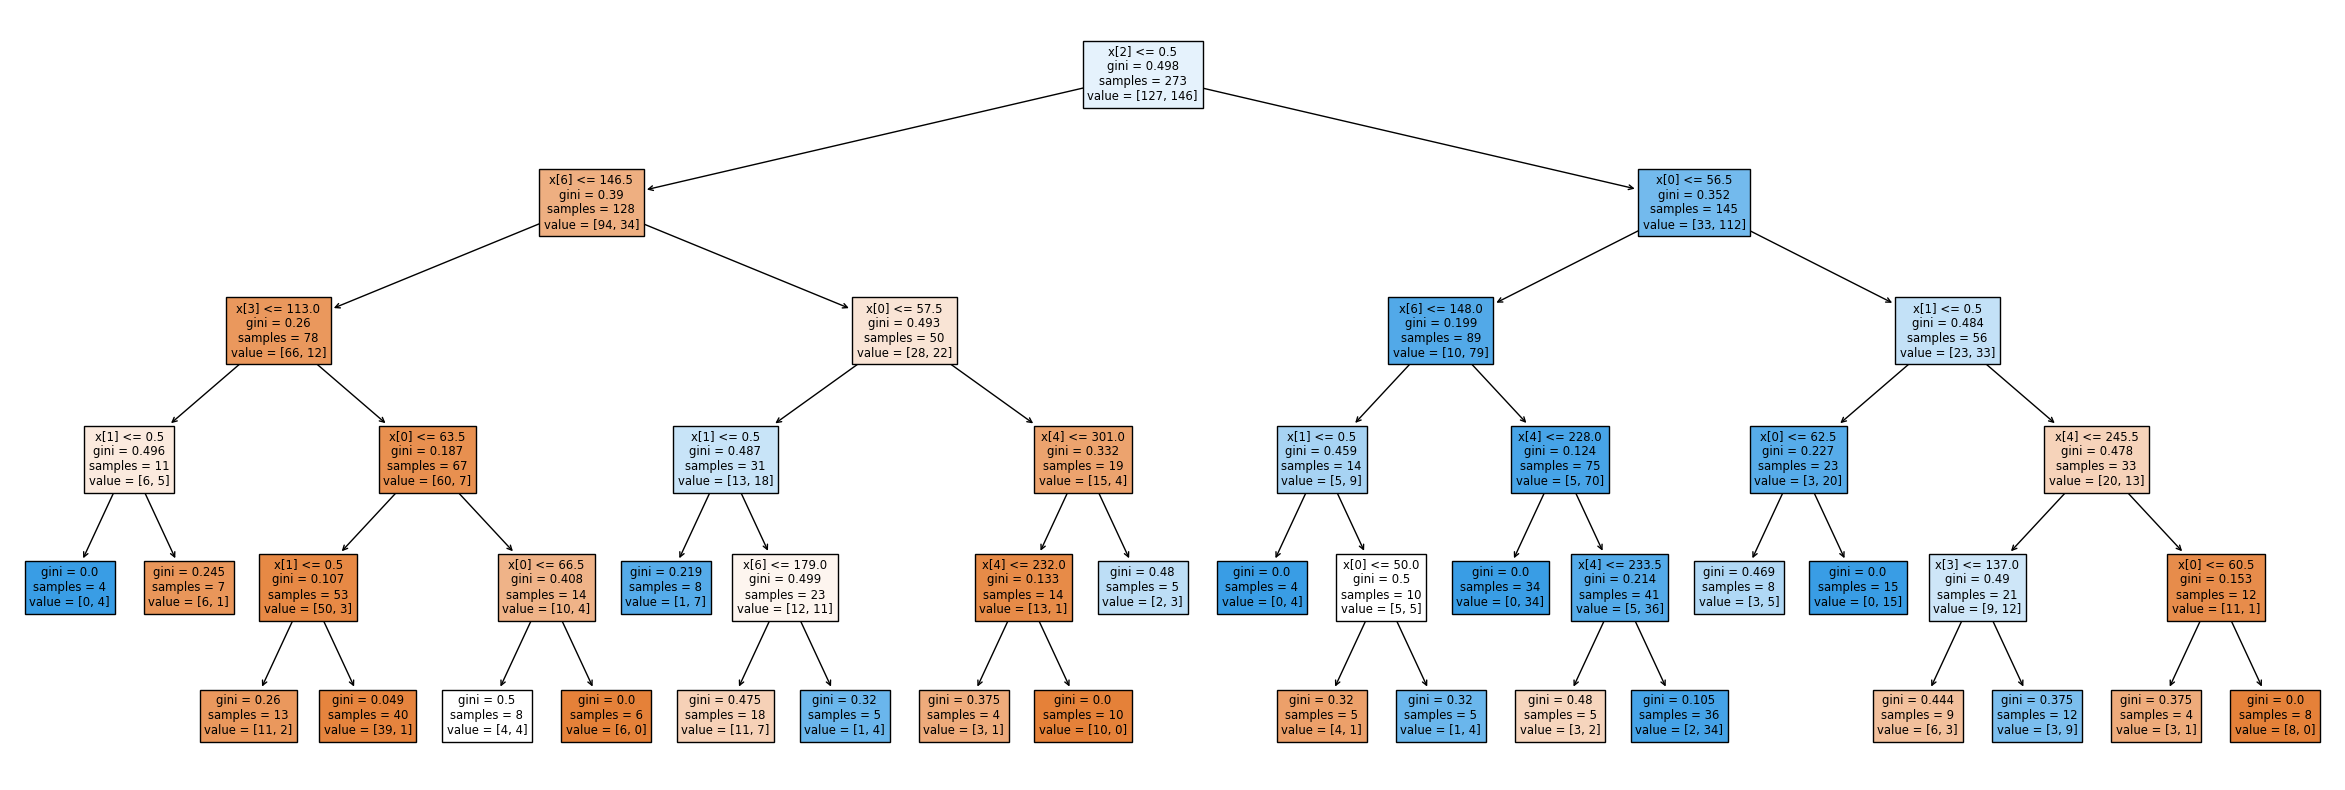

In [20]:
#Assisted by stackoverflow
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

model =  DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 4, min_samples_split = 10)

model = model.fit(X, y)
plt.figure(figsize=(30, 10))
plot_tree(model, filled=True)
plt.show()

In [21]:
#Assisted by GPT
importances = model.feature_importances_

# Create a dictionary to associate each feature with its importance
feature_importance_dict = dict(zip(X.columns, importances))

# Sort the features by importance (in descending order)
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

cp: 0.40674823107200503
age: 0.18431264176502093
sex: 0.15718399398865993
chol: 0.107270423881745
thalach: 0.09671263328436423
trtbps: 0.047772076008204864
restecg: 0.0


## Q4: Interpretation

The most important predictors to predicting heart attacks: <br>

KNN: No way to interpret the fit. <br>
Logistic Regression: Chest Pain Type (cp), Max Heart Rate during Exercise (thalach), and Sex. <br>
Decision Tree: Chest Pain Type (cp), Max Heart Rate during Exercise (thalach), and Sex. <br>

## Q5: ROC Curve

In [22]:
#KNN
knn_y_scores = knn_pipeline_10_fit.predict_proba(X)[:, 1]
fpr_knn, tpr_knn, threshold = roc_curve(y, knn_y_scores)
knn_roc_df = pd.DataFrame({"fpr_knn": fpr_knn,
                       "tpr_knn": tpr_knn})
#Logistic Regression
logreg_y_scores = log_reg_best_fit.predict_proba(X)[:, 1]
fpr_log, tpr_log, threshold = roc_curve(y, logreg_y_scores)
log_roc_df = pd.DataFrame({"fpr_log": fpr_log,
                       "tpr_log": tpr_log})
#Decision Tree
dt_y_scores = dtree_pipeline_5_fit.predict_proba(X)[:, 1]
fpr_dt, tpr_dt, threshold = roc_curve(y, dt_y_scores)
dt_roc_df = pd.DataFrame({"fpr_dt": fpr_dt,
                       "tpr_dt": tpr_dt})

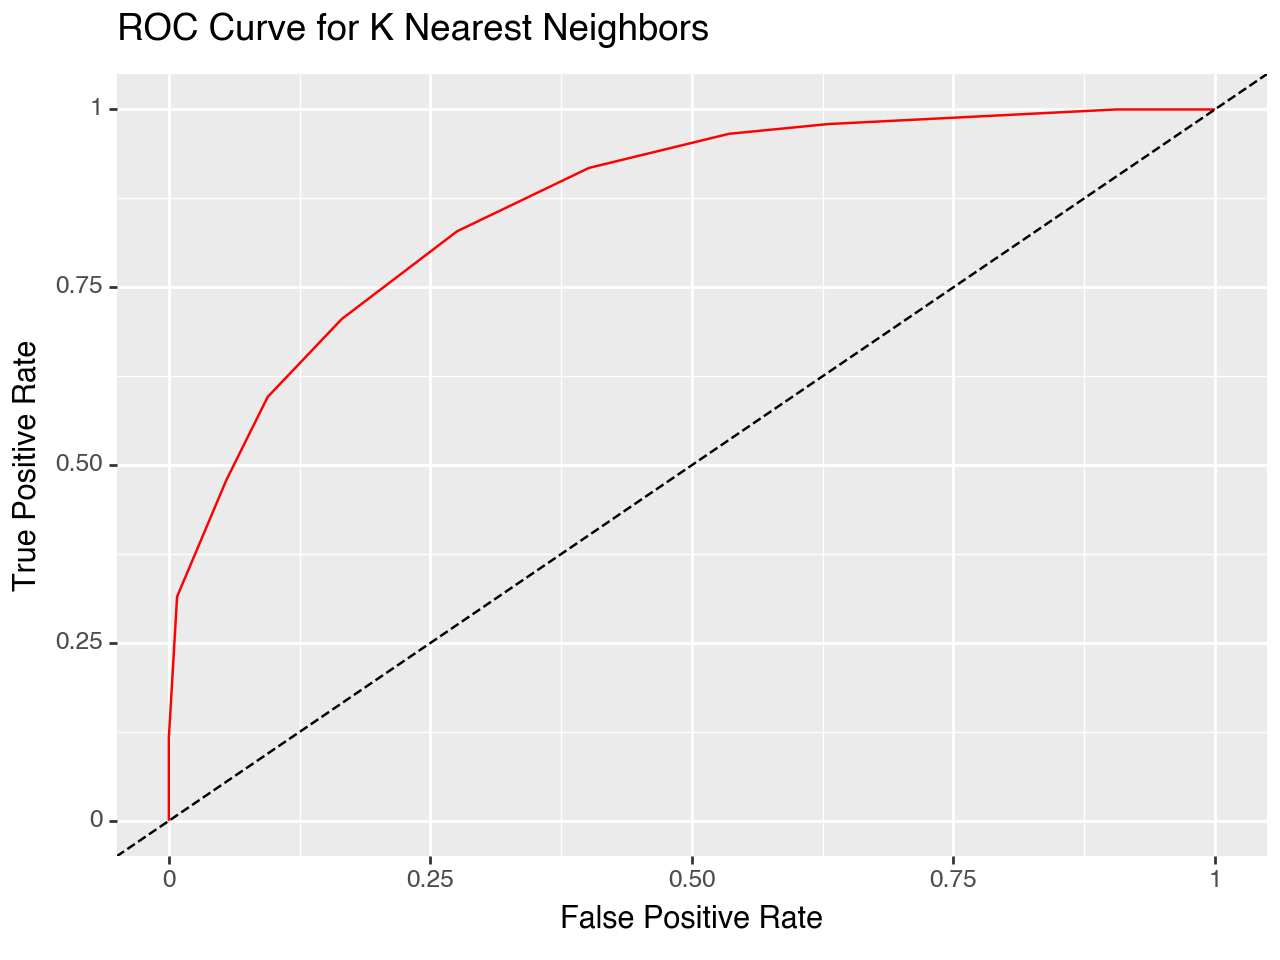

<Figure Size: (640 x 480)>

In [23]:
(ggplot(knn_roc_df, aes(x = "fpr_knn", y = "tpr_knn"))
 + geom_line(color = "red")
 + geom_abline(linetype='dashed')
 + xlab("False Positive Rate")
 + ylab("True Positive Rate")
 + ggtitle("ROC Curve for K Nearest Neighbors"))

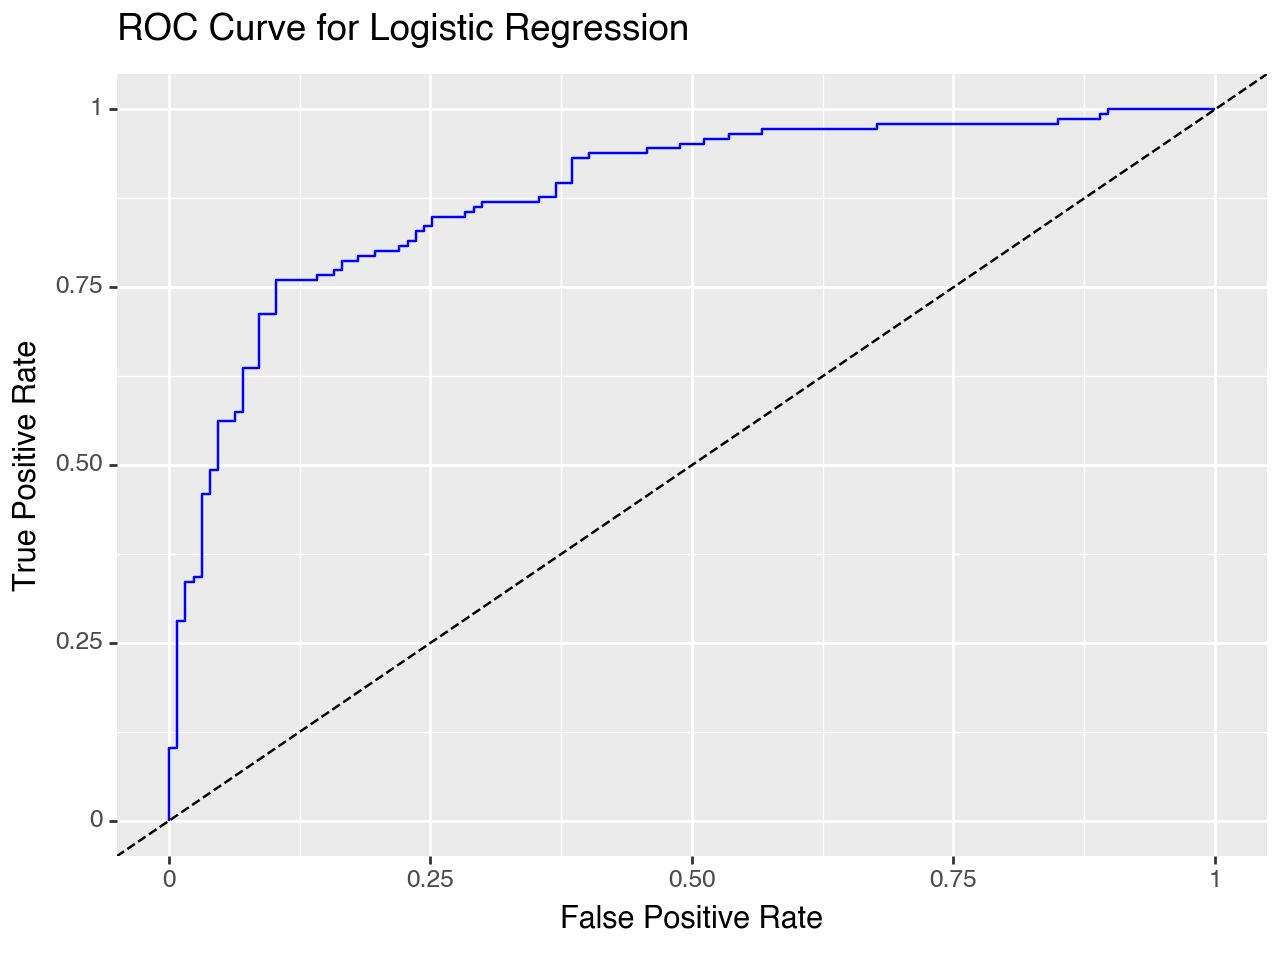

<Figure Size: (640 x 480)>

In [24]:
(ggplot(log_roc_df, aes(x = "fpr_log", y = "tpr_log"))
 + geom_line(color = "blue")
 + geom_abline(linetype='dashed')
 + xlab("False Positive Rate")
 + ylab("True Positive Rate")
 + ggtitle("ROC Curve for Logistic Regression"))

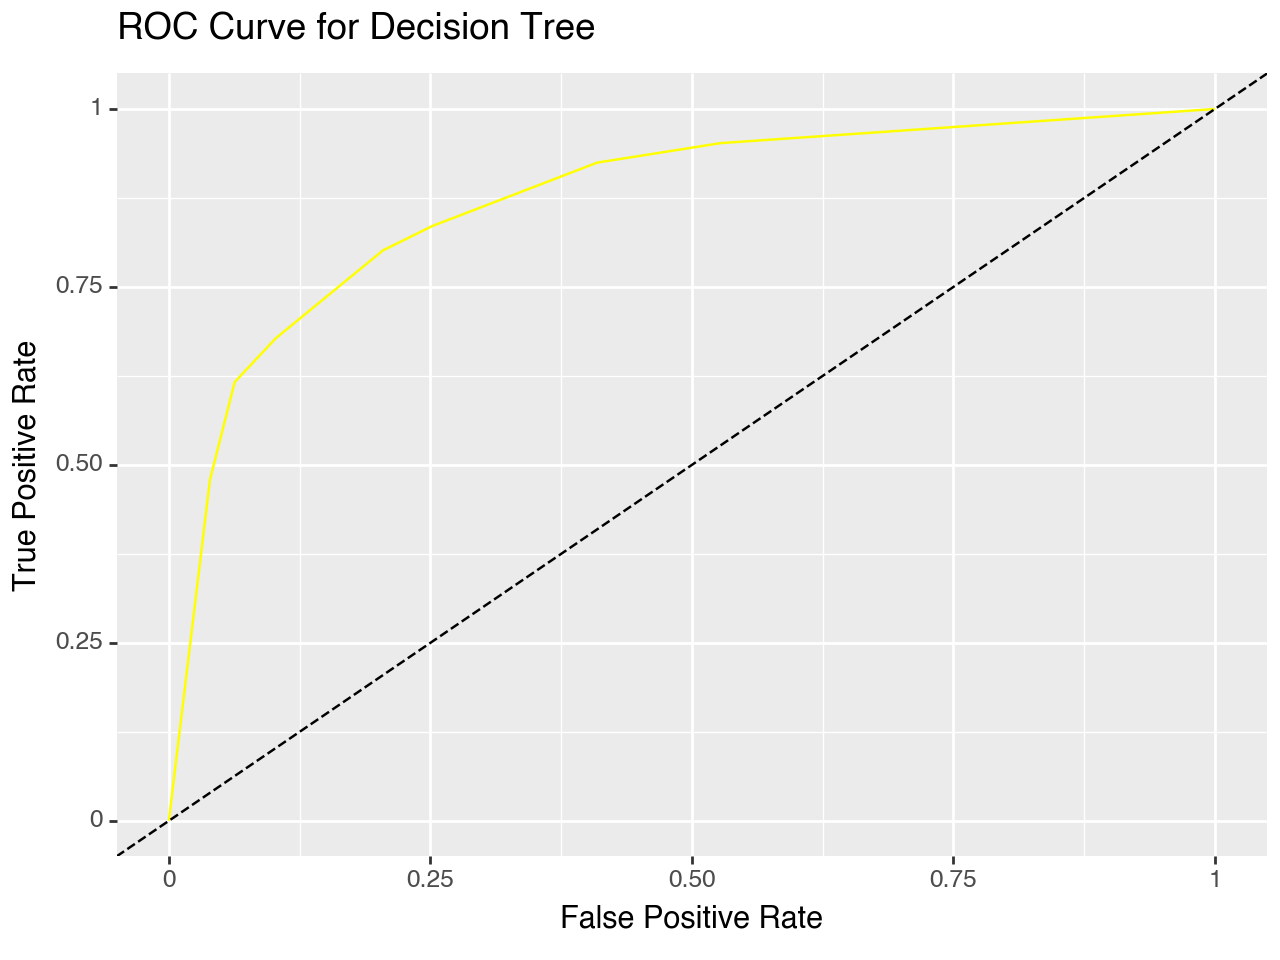

<Figure Size: (640 x 480)>

In [25]:
(ggplot(dt_roc_df, aes(x = "fpr_dt", y = "tpr_dt"))
 + geom_line(color = "yellow")
 + geom_abline(linetype='dashed')
 + xlab("False Positive Rate")
 + ylab("True Positive Rate")
 + ggtitle("ROC Curve for Decision Tree"))

# Part 2: Metrics

In [26]:
#KNN 
print(pd.DataFrame(confusion_matrix(y, knn_y_pred)))
print(f"KNN: Sensitivity: {103/(103+43)}")
print(f"KNN: Precision: {106/(106+21)}")
print(f"KNN: Specificity: {103/(103+21)}")

     0    1
0  106   21
1   43  103
KNN: Sensitivity: 0.7054794520547946
KNN: Precision: 0.8346456692913385
KNN: Specificity: 0.8306451612903226


In [27]:
#Logistic Regression
print(pd.DataFrame(confusion_matrix(y, log_reg_y_pred)))
print(f"Logistic: Sensitivity: {122/(122+24)}")
print(f"Logistic: Precision: {96/(96+31)}")
print(f"Logistic: Specificity: {122/(122+31)}")

    0    1
0  96   31
1  24  122
Logistic: Sensitivity: 0.8356164383561644
Logistic: Precision: 0.7559055118110236
Logistic: Specificity: 0.7973856209150327


In [28]:
#Decision Tree
print(pd.DataFrame(confusion_matrix(y, dtree_y_pred)))
print(f"D Tree: Sensitivity: {117/(117+29)}")
print(f"D Tree: Precision: {101/(101+26)}")
print(f"D Tree: Specificity: {117/(117+26)}")

     0    1
0  101   26
1   29  117
D Tree: Sensitivity: 0.8013698630136986
D Tree: Precision: 0.7952755905511811
D Tree: Specificity: 0.8181818181818182


# Part 3: Discussion

### Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack. <br>

Metric Used: Specificity (True Negative Rate), we want the highest rate of observations classified as low risk actually being low risk. <br>

Model Recommended: K Nearest Neighbors  <br>

Expected Score for Chosen Metric: 0.830645

### Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.<br>

Metric Used: Precision, we want a high proportion of all positives being correctly identified. <br>

Model Recommended: K Nearest Neighbors <br>

Expected Score for Chosen Metric: 0.834646

### Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.<br>

Metric Used: Sensitivity (True Positive Rate), we want the highest rate of all positives that are correctly identified. In order to study root causes, we would need to look at thise that actually have high risk of heart attacks. <br>

Model Recommended: Logistic Regression <br>

Expected Score for Chosen Metric: 0.835616

### Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.<br>

Metric Used: Sensitivity (True Positive Rate), to test the ability of doctors compared to the algorithm, they would need to evaluate the rate correctly identified of all positives. <br>

Model Recommended: Logisitc Regression <br>
Expected Score for Chosen Metric: 0.835616

# Part 4: Validation

In [29]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [30]:
X1 = ha_validation.drop(["output"], axis = 1)
y1 = ha_validation["output"]

## KNN Validation Data

In [31]:
knn_y1_pred = knn_pipeline_10_fit.predict(X1)
pd.DataFrame(confusion_matrix(y1, knn_y1_pred))

,0,1
0,10,1
1,9,10


In [32]:
print(f"KNN ROC AUC: {roc_auc_score(y1, knn_y1_pred)}")
print(f"KNN: Sensitivity: {9/(9+10)}")
print(f"KNN: Precision: {9/(9+2)}")

KNN ROC AUC: 0.7177033492822966
KNN: Sensitivity: 0.47368421052631576
KNN: Precision: 0.8181818181818182


Compared to Part 1 & 2, <br>
- ROC AUC was lower <br>
- Sensitivity was lower <br>
- Precision was higher

## Logistic Regression Validation Data

In [33]:
log_reg_y1_pred = log_reg_best_fit.predict(X1)
pd.DataFrame(confusion_matrix(y1, log_reg_y1_pred))

,0,1
0,9,2
1,5,14


In [34]:
print(f"Logistic ROC AUC: {roc_auc_score(y1, log_reg_y1_pred)}")
print(f"Logistic: Sensitivity: {13/(13+6)}")
print(f"Logistic: Precision: {13/(13+3)}")

Logistic ROC AUC: 0.777511961722488
Logistic: Sensitivity: 0.6842105263157895
Logistic: Precision: 0.8125


Compared to Part 1 & 2, <br>
- ROC AUC was lower <br>
- Sensitivity was higher <br>
- Precision was higher

## Decision Tree Validation Data

In [35]:
dtree_y1_pred = dtree_pipeline_5_fit.predict(X1)
pd.DataFrame(confusion_matrix(y1, dtree_y1_pred))

,0,1
0,9,2
1,7,12


In [36]:
print(f"Decision Tree ROC AUC: {roc_auc_score(y1, dtree_y1_pred)}")
print(f"D Tree: Sensitivity: {13/(13+6)}")
print(f"D Tree: Precision: {13/(13+3)}")

Decision Tree ROC AUC: 0.7248803827751196
D Tree: Sensitivity: 0.6842105263157895
D Tree: Precision: 0.8125


Compared to Part 1 & 2, <br>
- ROC AUC was lower <br>
- Sensitivity was lower <br>
- Precision was lower

# Part 5: Cohen's Kappa

In [37]:
from sklearn.metrics import cohen_kappa_score

print(f"KNN Cohen's Kappa: {cohen_kappa_score(y, knn_y_pred)}")
print(f"Logistic Cohen's Kappa: {cohen_kappa_score(y, log_reg_y_pred)}")
print(f"D Tree Cohen's Kappa: {cohen_kappa_score(y, dtree_y_pred)}")

KNN Cohen's Kappa: 0.5341048477414537
Logistic Cohen's Kappa: 0.5936510513923845
D Tree Cohen's Kappa: 0.5957297864893245


Cohen's Kappa is a statistic of how close a machine learning classifier matched the comparison data. Cohen's Kappa is a statistic between 1 and -1. Any negative value indicates that the matching is worse than expected by chance, suggesting systematic issues with the data. Given out Kappa statistic is around 0.5-0.6, we can say that we have moderate similarity. <br>

Our conclusions do change. According to Cohen's Kappa, our best model is the Decision Tree Model. According to our ROC AUC score in Part 1 and Part 4 (using the Validation dataset), the Logistic Regression Model was the best in discrminating between the high and low risk patients. <br>

Because each statistic is sensitive to different things, it is not surprising that the statistics indicate differing success between the classification models. For example, the Kappa Statistic may be skewed if there is an imbalance of observations between the categories.